In [1]:
# %pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
import peakdetect
from runmainsim import *
import tvbsim

import re
import sys
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility.signalprocessing as sp

%matplotlib inline
%load_ext autoreload
%autoreload 2

from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y
def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='highpass', analog=False)
    return b, a
def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

In [2]:
def getseiztimes(onsettimes, offsettimes):
    minsize = np.min((len(onsettimes),len(offsettimes)))
    seizonsets = []
    seizoffsets = []
    
    # perform some checks
    if minsize == 0:
        print("no full onset/offset available!")
        return 0
    
    idx = 0
    # to store the ones we are checking rn
    _onset = onsettimes[idx]
    _offset = offsettimes[idx]
    seizonsets.append(_onset)
    
    # start loop after the first onset/offset pair
    for i in range(1,minsize):        
        # to store the previoius values
        _nextonset = onsettimes[i]
        _nextoffset = offsettimes[i]
        
        # check this range and add the offset if it was a full seizure
        # before the next seizure
        if _nextonset < _offset:
            _offset = _nextoffset
        else:
            seizoffsets.append(_offset)
            idx = i
            # to store the ones we are checking rn
            _onset = onsettimes[idx]
            _offset = offsettimes[idx]
            seizonsets.append(_onset)
    if len(seizonsets) != len(seizoffsets):
        seizonsets = seizonsets[0:len(seizoffsets)]
    return seizonsets, seizoffsets
            
def getonsetsoffsets(zts, ezindices, pzindices):
    # create lambda function for checking the indices
    check = lambda indices: isinstance(indices,np.ndarray) and len(indices)>=1

    onsettimes=np.array([])
    offsettimes=np.array([])
    if check(ezindices):
        for ezindex in ezindices:
            _onsettimes, _offsettimes = postprocessor.findonsetoffset(zts[ezindex, :].squeeze(), 
                                                                    delta=0.2/8)
            onsettimes = np.append(onsettimes, np.asarray(_onsettimes))
            offsettimes = np.append(offsettimes, np.asarray(_offsettimes))

    if check(pzindices):
        for pzindex in pzindices:
            _onsettimes, _offsettimes = postprocessor.findonsetoffset(zts[pzindex, :].squeeze(), 
                                                                    delta=0.2/8)
            onsettimes = np.append(onsettimes, np.asarray(_onsettimes))
            offsettimes = np.append(offsettimes, np.asarray(_offsettimes))

    # first sort onsettimes and offsettimes
    onsettimes.sort()
    offsettimes.sort()
    
    return onsettimes, offsettimes

In [68]:
### RUN ONCES

# get the cortical surface meta data
metadatadir = os.path.join("/Users/adam2392/Documents/pydata/metadata/", patient)
cort_surf = surfaces.CorticalSurface.from_file(source_file=os.path.join(metadatadir, "surface_cort.zip"))
cort_surf.configure()
display(cort_surf.summary_info)

{'Edge lengths, longest (mm)': 11.32615848876635,
 'Edge lengths, mean (mm)': 1.0372261079362926,
 'Edge lengths, shortest (mm)': 0.018795094413170094,
 'Has two hemispheres': False,
 'Number of edges': 689340,
 'Number of triangles': 459560,
 'Number of vertices': 229784,
 'Surface type': 'CorticalSurface',
 'Valid for simulations': False}

# 1. Set Up Simulation Configuration First - Move Contact
Here, set everything from the ez region, connectivity, node model, coupling, monitors, integrator, and parameters.

In [3]:
patients = ['id001_ac', 'id002_cj']#, 'id014_rb']
patients = ['id001_ac']

MOVECONTACT = 1
movedistance = 0
# patients = ['id001_ac']
for patient in patients:
    print patient
#     patient='cj'
    # 1000 = 1 second
    samplerate = 1000 # Hz
    sim_length = 600*samplerate
    period = 1
        
    ######### Epileptor Parameters ##########
    # intialized hard coded parameters
    epileptor_r = 0.0002#/1.5   # Temporal scaling in the third state variable
    epiks = -1                  # Permittivity coupling, fast to slow time scale
    epitt = 0.025               # time scale of simulation
    epitau = 4                # Temporal scaling coefficient in fifth st var
    
    # x0c value = -2.05
    x0norm=-2.4
    x0ez=-1.7
    x0pz=-2.0

    eznum = 1
    pznum = 3
    # depends on epileptor variables of interest: it is where the x2-y2 var is
    varindex = [1]
    
    ######### Integrator Parameters ##########
    # parameters for heun-stochastic integrator
    heun_ts = 0.05
    noise_cov = np.array([0.001, 0.001, 0.,\
                    0.0001, 0.0001, 0.])/3
  
    root_dir = os.path.join('/Users/adam2392/Documents/pydata/')
    project_dir = os.path.join(root_dir, "metadata/",patient)
    print "Project directory for meta data is : ", project_dir
    tvbsim.util.renamefiles(patient, project_dir)
    
    ####### Initialize files needed to run tvb simulation
    sensorsfile = os.path.join(project_dir, "seeg.txt")
    gainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
    confile = os.path.join(project_dir, "connectivity.zip")
    
    use_subcort = 1
    verts, normals, areas, regmap = tvbsim.util.read_surf(project_dir, use_subcort)

    ####################### 1. Structural Connectivity ########################
    con = tvbsim.initializers.connectivity.initconn(confile)
    
    # extract the seeg_xyz coords and the region centers
    seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
    seeg_labels = seeg_xyz.index.values
    region_centers = con.centres
    regions = con.region_labels
    num_regions = len(regions)
    
    # initialize object to assist in moving seeg contacts
    movecontact = tvbsim.util.MoveContacts(seeg_labels, seeg_xyz, 
                                       regions, region_centers, True)
    

    randez = np.random.randint(0, len(regions), size=eznum)
    randpz = np.random.randint(0, len(regions), size=pznum)

    if eznum <= 1:
        ezregion = list(regions[randez])
    else:
        ezregion = regions[randez]
    if pznum >= 1:
        pzregion = list(regions[randpz])
    elif pznum == 0:
        pzregion = []
    else:
        print >> sys.stderr, "Not implemented pz num >= 1 yet"
        raise
    
    if MOVECONTACT:
        ezindices = movecontact.getindexofregion(ezregion)
        pzindices = movecontact.getindexofregion(pzregion)
        
        ########## MOVE INDICES
        # move electrodes onto ez indices
        elecmovedindices = []
        for ezindex in ezindices:
            print "Moving onto current ez index: ", ezindex, " at ", regions[ezindex]
             # find the closest contact index and distance
            seeg_index, distance = movecontact.findclosestcontact(ezindex, elecmovedindices)

            # get the modified seeg xyz and gain matrix
            if movedistance != 0:
                modseeg, electrodeindices = movecontact.movecontactto(ezindex, seeg_index, distance)
            else:
                print "\n\nmoved contact onto ez exactly!!!!\n\n"
                modseeg, electrodeindices = movecontact.movecontact(ezindex, seeg_index)
            elecmovedindices.append(electrodeindices)
        
        # use subcortical structures!
        use_subcort = 1
        verts, normals, areas, regmap = tvbsim.util.read_surf(project_dir, use_subcort)
        modgain = tvbsim.util.gain_matrix_inv_square(verts, areas,
                            regmap, len(regions), movecontact.seeg_xyz)
        print "modified gain matrix the TVB way!"
    elif MOVECONTACT == 0:
        ########## SET EZREGION BASED ON CLOSENESS
        # find the closest region-contact pair
        for idx, label in enumerate(seeg_labels):
            region_index, distance = movecontact.getregionsforcontacts(label)

            if idx == 0:
                mindist = distance
                minregion = region_index
                mincontact = label
            else:
                if distance < mindist:
                    mindist = distance
                    minregion = region_index
                    mincontact = label
                    
        ezregion = minregion

    outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/', 
                             'nez'+str(len(ezregion))+'_npz'+str(len(pzregion)))
#                              patient)
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    ezindices = movecontact.getindexofregion(ezregion)
    pzindices = movecontact.getindexofregion(pzregion)
    
    if not isinstance(ezindices, list):
        ezindices = np.array([ezindices])
    if not isinstance(pzindices, list):
        pzindices = np.array([pzindices])

    filename = os.path.join(outputdir, patient+'_sim_nez'+str(len(ezregion))+\
                                        '_npz'+str(len(pzregion))+'.npz')
    print "Project directory for meta data is : ", project_dir
    print "File to be saved is: ", filename
    
    ####################### 2. Neural Mass Model @ Nodes ######################
    epileptors = tvbsim.initializers.models.initepileptor(epileptor_r, epiks, epitt, epitau, x0norm, \
                              x0ez, x0pz, ezindices, pzindices, num_regions)    
    ####################### 3. Integrator for Models ##########################
    heunint = tvbsim.initializers.integrators.initintegrator(heun_ts, noise_cov, noiseon=True)
    
    ################## 4. Difference Coupling Between Nodes ###################
    coupl = tvbsim.initializers.coupling.initcoupling(a=1.)
    
    ############## 5. Import Sensor XYZ, Gain Matrix For Monitors #############
    monitors = tvbsim.initializers.monitors.initmonitors(period, sensorsfile, gainmatfile, varindex)
    
    if MOVECONTACT:
        # check distance of 
        
        # modify the config of the monitors
        monitors[1].sensors.locations = movecontact.seeg_xyz
        monitors[1].sensors.locations = modseeg
        monitors[1].gain = modgain
        
    # get initial conditions and then setup entire simulation configuration
    initcond = initconditions(x0norm, num_regions)
    sim, configs = setupconfig(epileptors, con, coupl, heunint, monitors, initcond)
    times, epilepts, seegts = runsim(sim, sim_length)

    postprocessor = tvbsim.util.PostProcess(epilepts, seegts, times)
    ######################## POST PROCESSING #################################
    # post process by cutting off first 5 seconds of simulation
    # for now, don't, since intiial conditions
    times, epits, seegts, zts = postprocessor.postprocts(samplerate)
    
    print ezindices
    print pzindices
    seizonsets = []
    seizoffsets = []

    try:
        # get the onsettimes and offsettimes for ez/pz indices
        onsettimes, offsettimes = getonsetsoffsets(zts, np.array(ezindices), np.array(pzindices))

        print("\nseizure onsets:", onsettimes)
        print("seizure offsets:", offsettimes)
        minsize = np.min((len(onsettimes),len(offsettimes)))

        # get the actual seizure times and offsets
        seizonsets, seizoffsets = getseiztimes(onsettimes, offsettimes)

        print(seizonsets, seizoffsets)
        print(onsettimes, offsettimes)
    except:
        print("try again")
    cutoff = None

    lowcut = 0.1
    highcut = 499.
    fs = 1000.
    x = seegts
    # y = butter_highpass_filter(x, lowcut, fs, order=4)
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=4)
    
    ######################## SAVING ALL DATA #################################
    regions = configs.connectivity.region_labels

    # Save files
    meta = {
        'x0ez':x0ez,
        'x0pz':x0pz,
        'x0norm':x0norm,
        'regions': regions,
        'regions_centers': configs.connectivity.centres,
        'seeg_contacts': configs.monitors[1].sensors.labels,
        'seeg_xyz': configs.monitors[1].sensors.locations,
        'ez': regions[ezindices],
        'pz': regions[pzindices],
        'ezindices': ezindices,
        'pzindices': pzindices,
        'onsettimes':seizonsets,
        'offsettimes':seizoffsets,
        'patient':patient,
    }

    # save tseries
    np.savez_compressed(filename, epits=epits, seegts=y, \
             times=times, zts=zts, metadata=meta)

id001_ac
Project directory for meta data is :  /Users/adam2392/Documents/pydata/metadata/id001_ac
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
Moving onto current ez index:  21  at  ctx-lh-posteriorcingulate


moved contact onto ez exactly!!!!


CC1
CC1
[  6.07  -3.81  43.37]


 movecontact function summary: 

('Closest contact to ezregion: ', array([ -1.4635, -39.9874,  50.5195]), ' is ', 'CC1')
('That is located at: ', array([ -1.4635, -39.9874,  50.5195]))
('It will move: ', [-7.5335000000000001, -36.177399999999999, 7.1495000000000033])
('New location after movement is', array([ -1.4635, -39.9874,  50.5195]))
modified gain matrix the TVB way!
Project directory for meta data is :  /Users/adam2392/Documents/pydata/metadata/id001_ac
File to be saved is:  /Users/adam2392/Documents/pydata/tvbforwardsim/nez1_npz3/id001_ac_sim_nez1_npz3.npz
[[21]]
[[58 29 76]]
try again


In [107]:
# get initial conditions and then setup entire simulation configuration
initcond = initconditions(x0norm, num_regions)
sim, configs = setupconfig(epileptors, con, coupl, heunint, monitors, initcond)
times, epilepts, seegts = runsim(sim, sim_length)

postprocessor = tvbsim.util.PostProcess(epilepts, seegts, times)
######################## POST PROCESSING #################################
# post process by cutting off first 5 seconds of simulation
# for now, don't, since intiial conditions
times, epits, seegts, zts = postprocessor.postprocts(samplerate)

In [108]:
print ezindices
print pzindices
seizonsets = []
seizoffsets = []

try:
    # get the onsettimes and offsettimes for ez/pz indices
    onsettimes, offsettimes = getonsetsoffsets(zts, np.array(ezindices), np.array(pzindices))

    print("\nseizure onsets:", onsettimes)
    print("seizure offsets:", offsettimes)
    minsize = np.min((len(onsettimes),len(offsettimes)))

    # get the actual seizure times and offsets
    seizonsets, seizoffsets = getseiztimes(onsettimes, offsettimes)

    print(seizonsets, seizoffsets)
    print(onsettimes, offsettimes)
except:
    print("try again")
cutoff = None
# if len(onsettimes) > len(offsettimes):
#     nextindex = np.where(onsettimes > seizoffsets[-1])[0][0]
#     # create a cutoff for the entire simulated data
#     cutoff = np.mean([onsettimes[nextindex], seizoffsets[-1]])

#     print onsettimes[minsize], seizoffsets[-1]

#     # floor to the nearest sample rate
#     cutoff = int(math.floor(cutoff / float(samplerate)) * float(samplerate))

#     plt.axvline(cutoff, color='red')
#     epits = epits[:,0:cutoff]
#     seegts = seegts[:, 0:cutoff]
#     zts = zts[:, 0:cutoff]
#     times = times[0:cutoff]

[[75]]
[[64 29]]
try again


In [109]:
lowcut = 0.1
highcut = 499.
fs = 1000.
x = seegts
# y = butter_highpass_filter(x, lowcut, fs, order=4)
y = butter_bandpass_filter(x, lowcut, highcut, fs, order=4)

In [110]:
######################## SAVING ALL DATA #################################
regions = configs.connectivity.region_labels

# Save files
meta = {
    'x0ez':x0ez,
    'x0pz':x0pz,
    'x0norm':x0norm,
    'regions': regions,
    'regions_centers': configs.connectivity.centres,
    'seeg_contacts': configs.monitors[1].sensors.labels,
    'seeg_xyz': configs.monitors[1].sensors.locations,
    'ez': regions[ezindices],
    'pz': regions[pzindices],
    'ezindices': ezindices,
    'pzindices': pzindices,
    'onsettimes':seizonsets,
    'offsettimes':seizoffsets,
    'patient':patient,
}

# save tseries
np.savez_compressed(filename, epits=epits, seegts=y, \
         times=times, zts=zts, metadata=meta)

## Visualize Results (If You want)

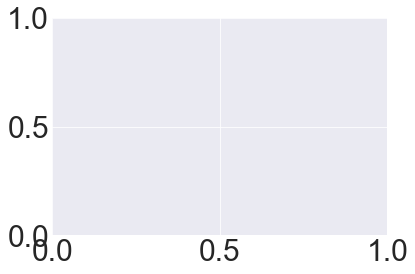

In [111]:
### Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'family':'Arial', 'size':'30'}

color_new = ['peru', 'dodgerblue', 'slategrey', 
             'skyblue', 'springgreen', 'fuchsia', 'limegreen', 
             'orangered',  'gold', 'crimson', 'teal', 'blueviolet', 'black', 'cyan', 'lightseagreen',
             'lightpink', 'red', 'indigo', 'mediumorchid', 'mediumspringgreen']

rawplotter = tvbsim.visualize.RawPlotter(axis_font, title_font, color_new)

[]
[[75]]
ezreion is:  [['ctx-rh-superiorfrontal']]
pzregion is:  [['ctx-rh-paracentral' 'ctx-lh-supramarginal']]
x0 values are (ez, pz, norm):  -1.7 -2.0 -2.4
time series shape is:  (84, 180000)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
here: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]


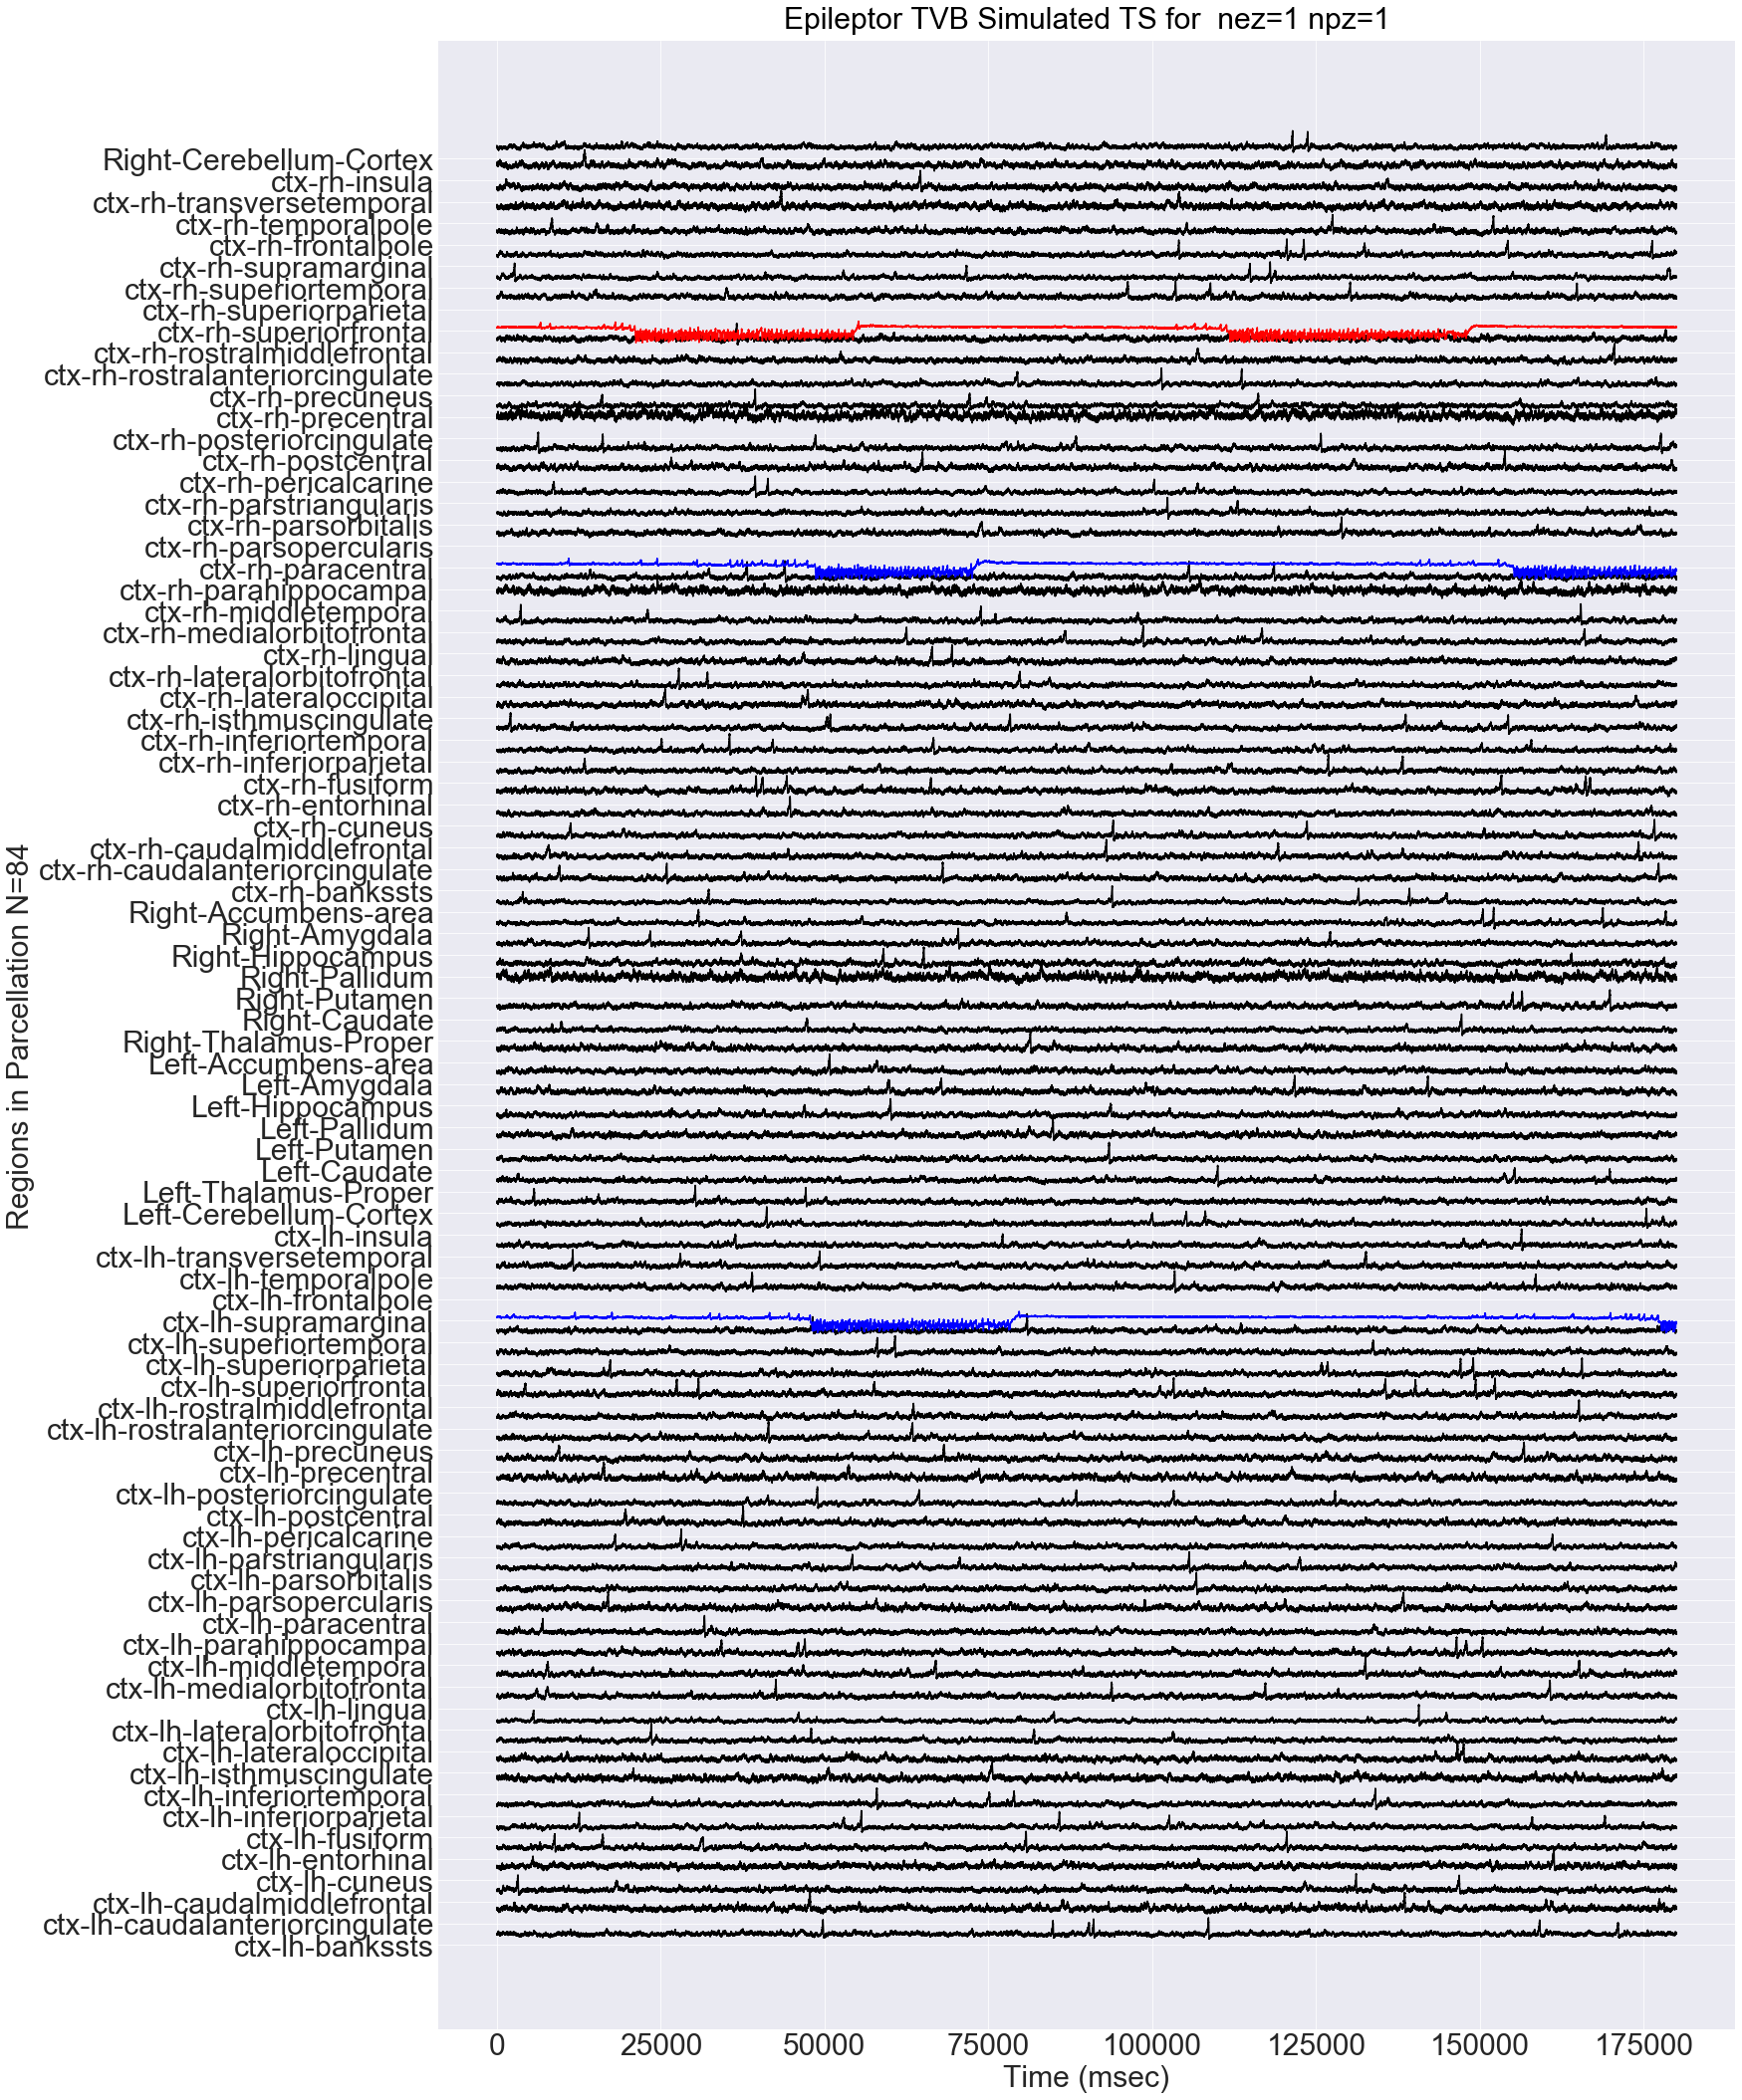

In [112]:
onsettimes = []
offsettimes = []
print onsettimes
print meta['ezindices']
rawplotter.initializefig(figsize=(25,30))
epifig = rawplotter.plotepileptorts(epits, times, meta, onsettimes, offsettimes, plotsubset=False)

ez seeg index is:  []
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
here: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]


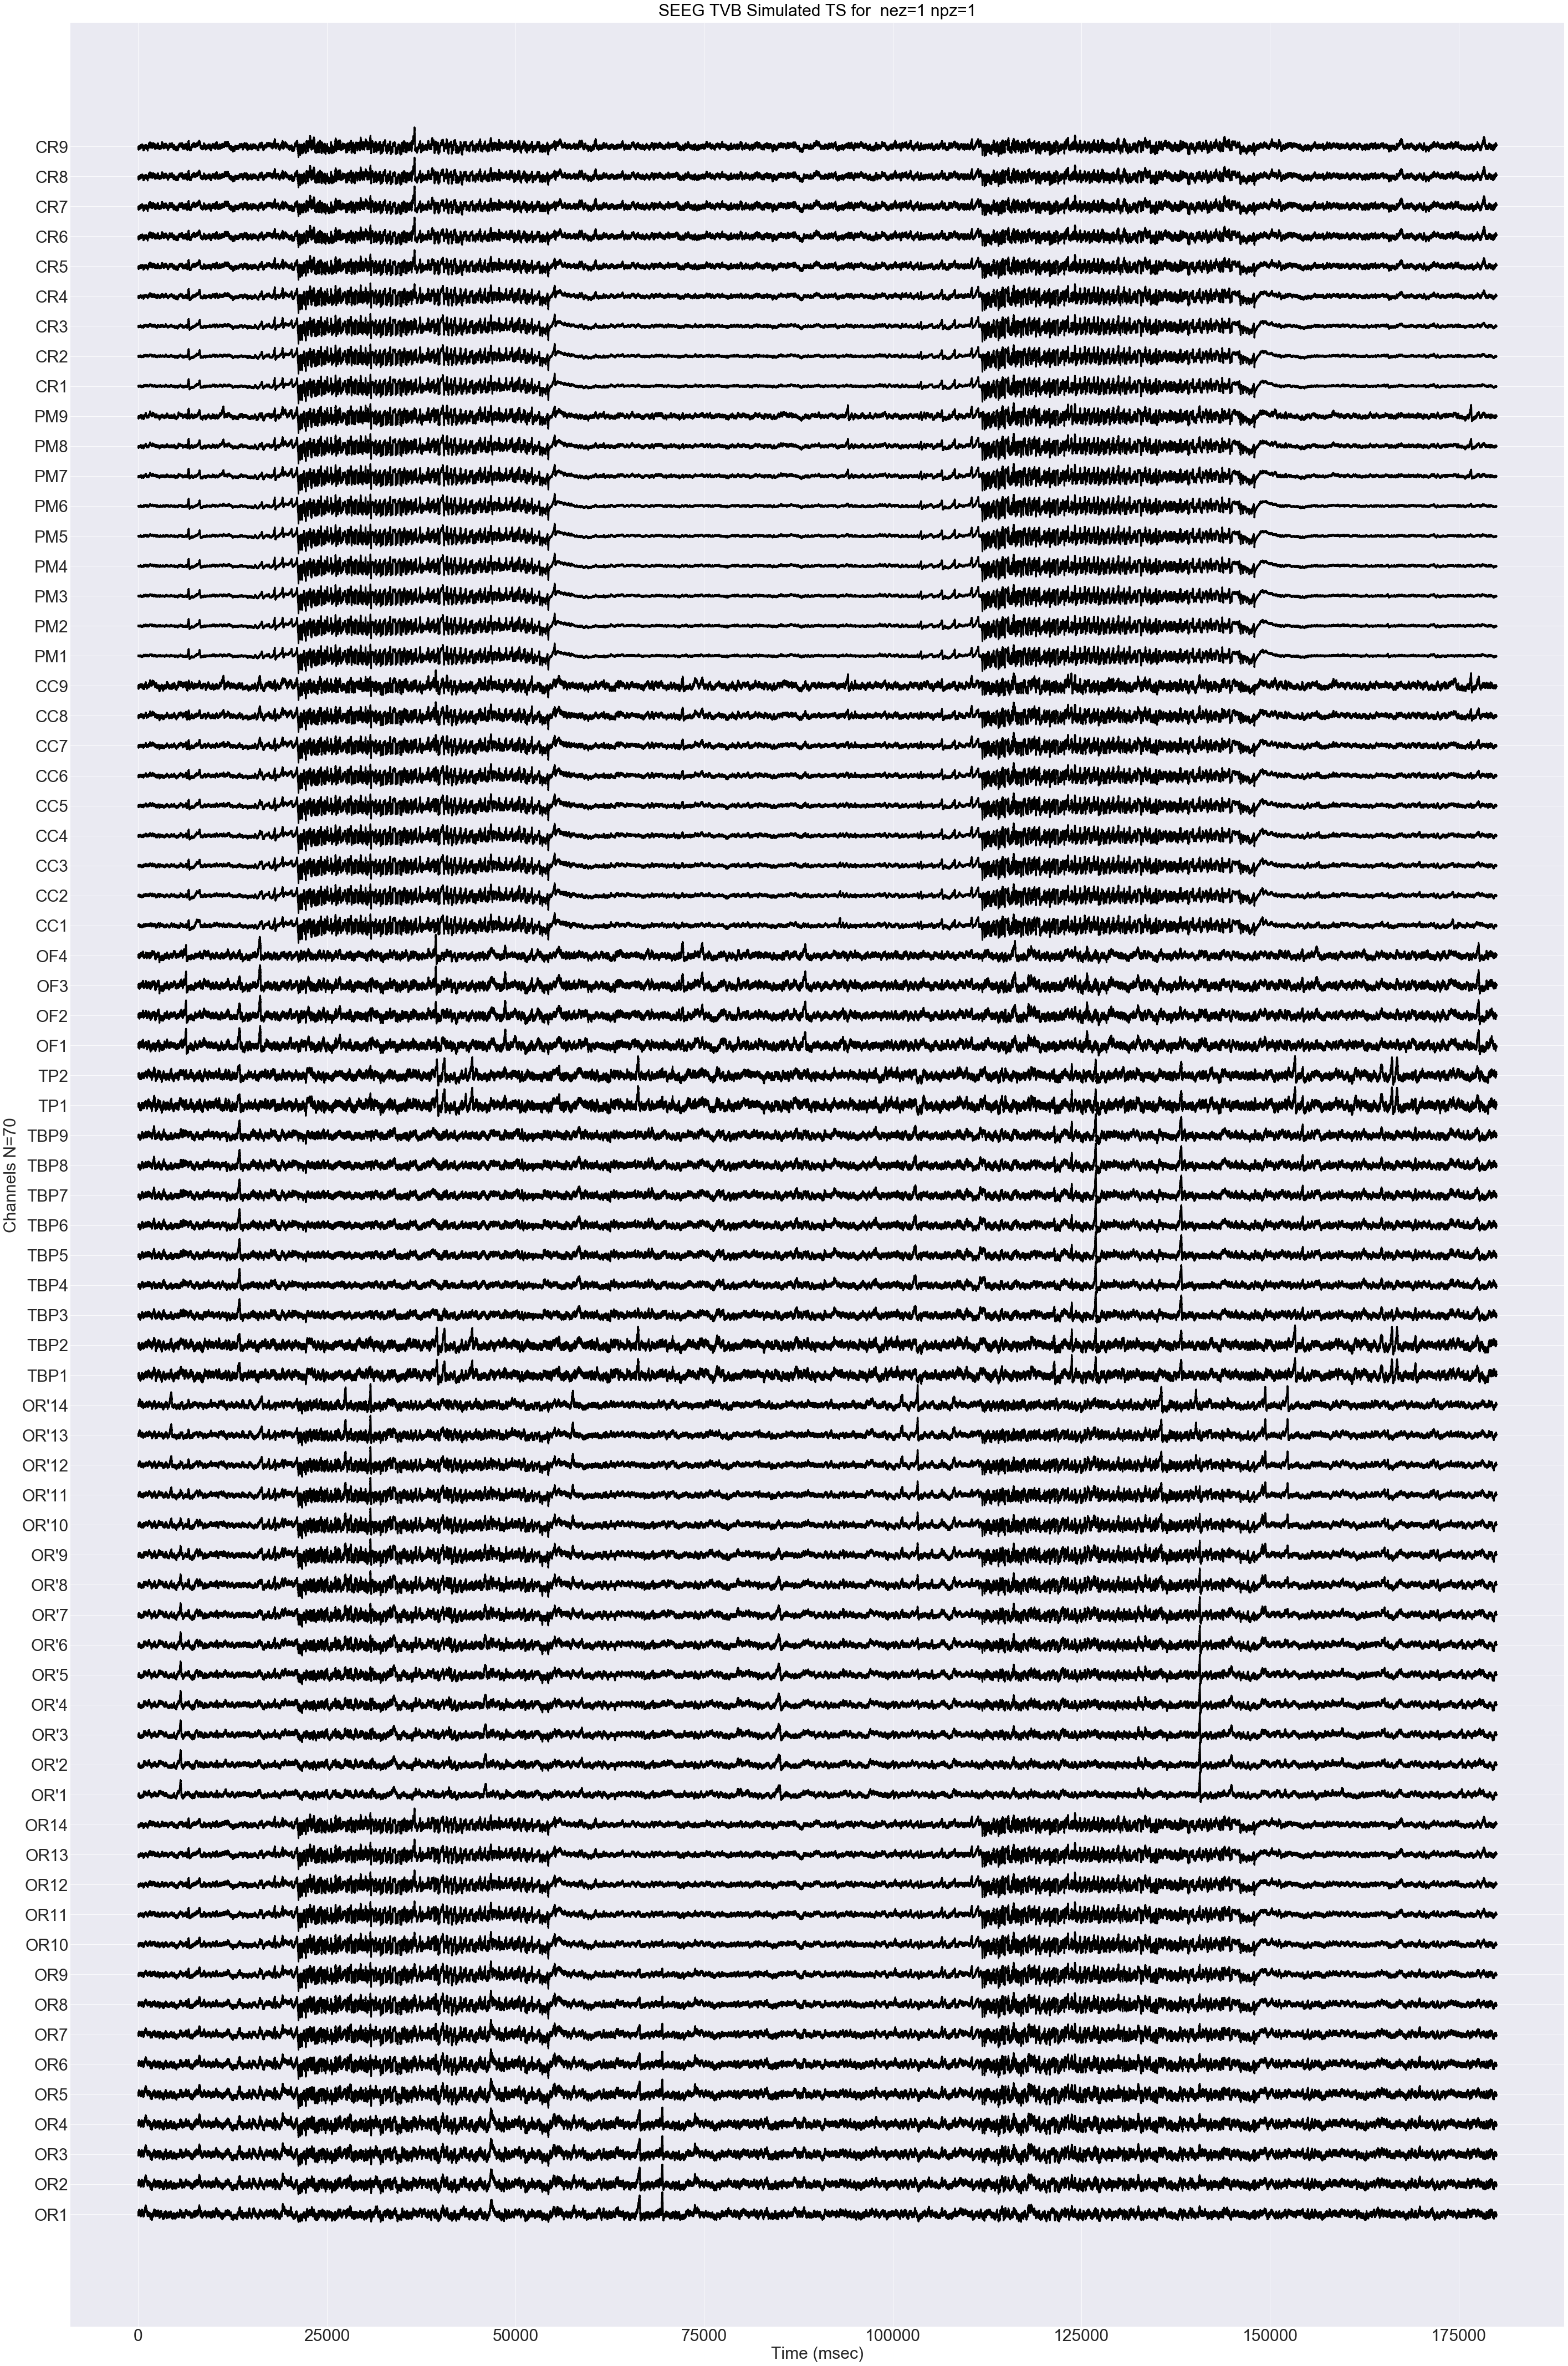

ez seeg index is:  []
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
here: [ 54.  27.   2.]


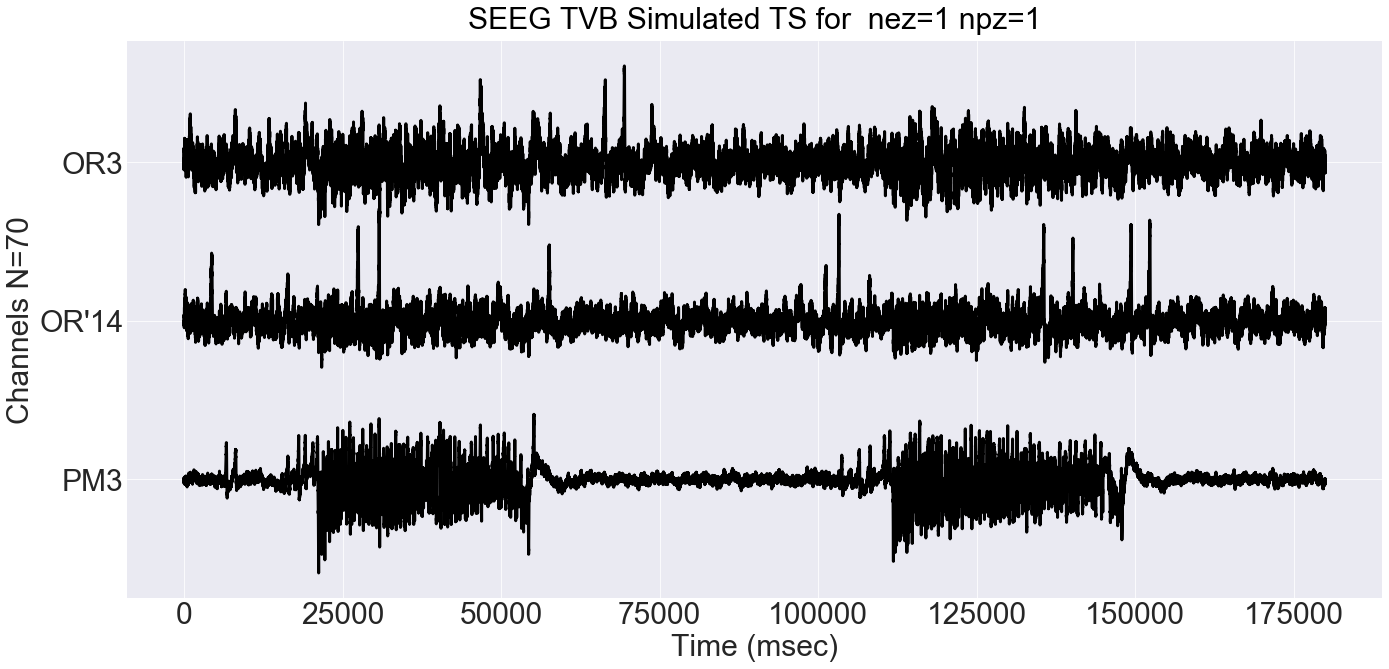

In [113]:
onsettimes = []
offsettimes = []
# rawplotter.initializefig(figsize=(20, 10))
# seegfig = rawplotter.plotseegts(y, times, meta, onsettimes, offsettimes, plotsubset=True)

rawplotter.initializefig(figsize=(40, 60))
seegfig = rawplotter.plotseegts(y, times, meta, onsettimes, offsettimes, plotsubset=False)

rawplotter.initializefig(figsize=(20, 10))
seegfig = rawplotter.plotseegts(y, times, meta, onsettimes, offsettimes, plotsubset=True)


Nbre_contacts_per_electrode: [14, 14, 9, 2, 4, 9, 9, 9]
Nbre_electrodes: 8
Ending Index of electrodes: [14 28 37 39 43 52 61 70]
70
70


NameError: name 'cort_surf' is not defined

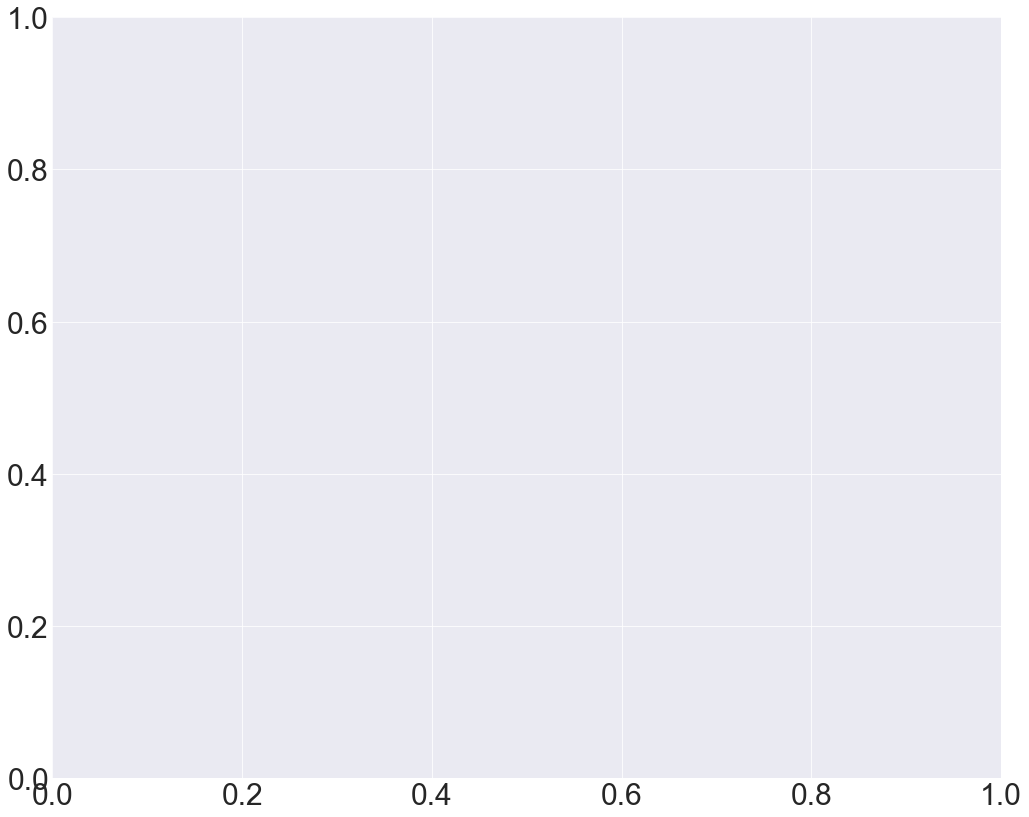

In [64]:
# read in seeg file
# seeg = pd.read_csv(os.path.join(metadatadir, "seeg.txt"), names=['x', 'y', 'z'], delim_whitespace=True)
# seeg_labels = seeg.index
# seeg_xyz = seeg.as_matrix()
seeg_labels = meta['seeg_contacts']
seeg_xyz = meta['seeg_xyz']

elect = []
dipole = []

# create lists of elect and dipoles
for element in range(0,seeg_labels.shape[0]):
    kpm = np.array(re.match("([A-Z]+[a-z]*[']*)([0-9]+)", seeg_labels[element]).groups())
    elect.append(kpm[0])
    dipole.append(int(kpm[1]))

'''
Descrip: 
- Number of electrodes is : len(find_0)
- Number of contacts per an electrode i is nbr_contacts[i+1]

''' 
# find the beginning index of each electrode
find_0 = []
nbr_contacts = []
for element_1 in range(0, len(dipole)):
    if dipole[element_1] == 1:
        find_0.append(element_1)
for element_2 in range(0, len(find_0)-1):
    nbr_contacts.append(find_0[element_2+1]-find_0[element_2])
nbr_contacts.append(len(seeg_labels)- find_0[len(find_0)-1])

# Find the list of the ending index of each electrode
incr_cont = np.zeros((len(nbr_contacts)), dtype=int)
incr_cont[0] = 0

for element_4 in range(0, len(nbr_contacts)):
    incr_cont[element_4] = incr_cont[element_4-1] + nbr_contacts[element_4]

    
print "Nbre_contacts_per_electrode:", nbr_contacts
print "Nbre_electrodes:", len(nbr_contacts)
print "Ending Index of electrodes:", incr_cont # To plot each electrode with diff color

print sum(nbr_contacts) # to be sure that the code is correct
print len(seeg_labels)

rawplotter.initializefig(figsize=(17,14))
rawplotter.plotcontactsinbrain(cort_surf, region_centers, regions, seeg_xyz, seeg_labels, incr_cont, patient, ezindices, pzindices=[])

IndexError: list index out of range

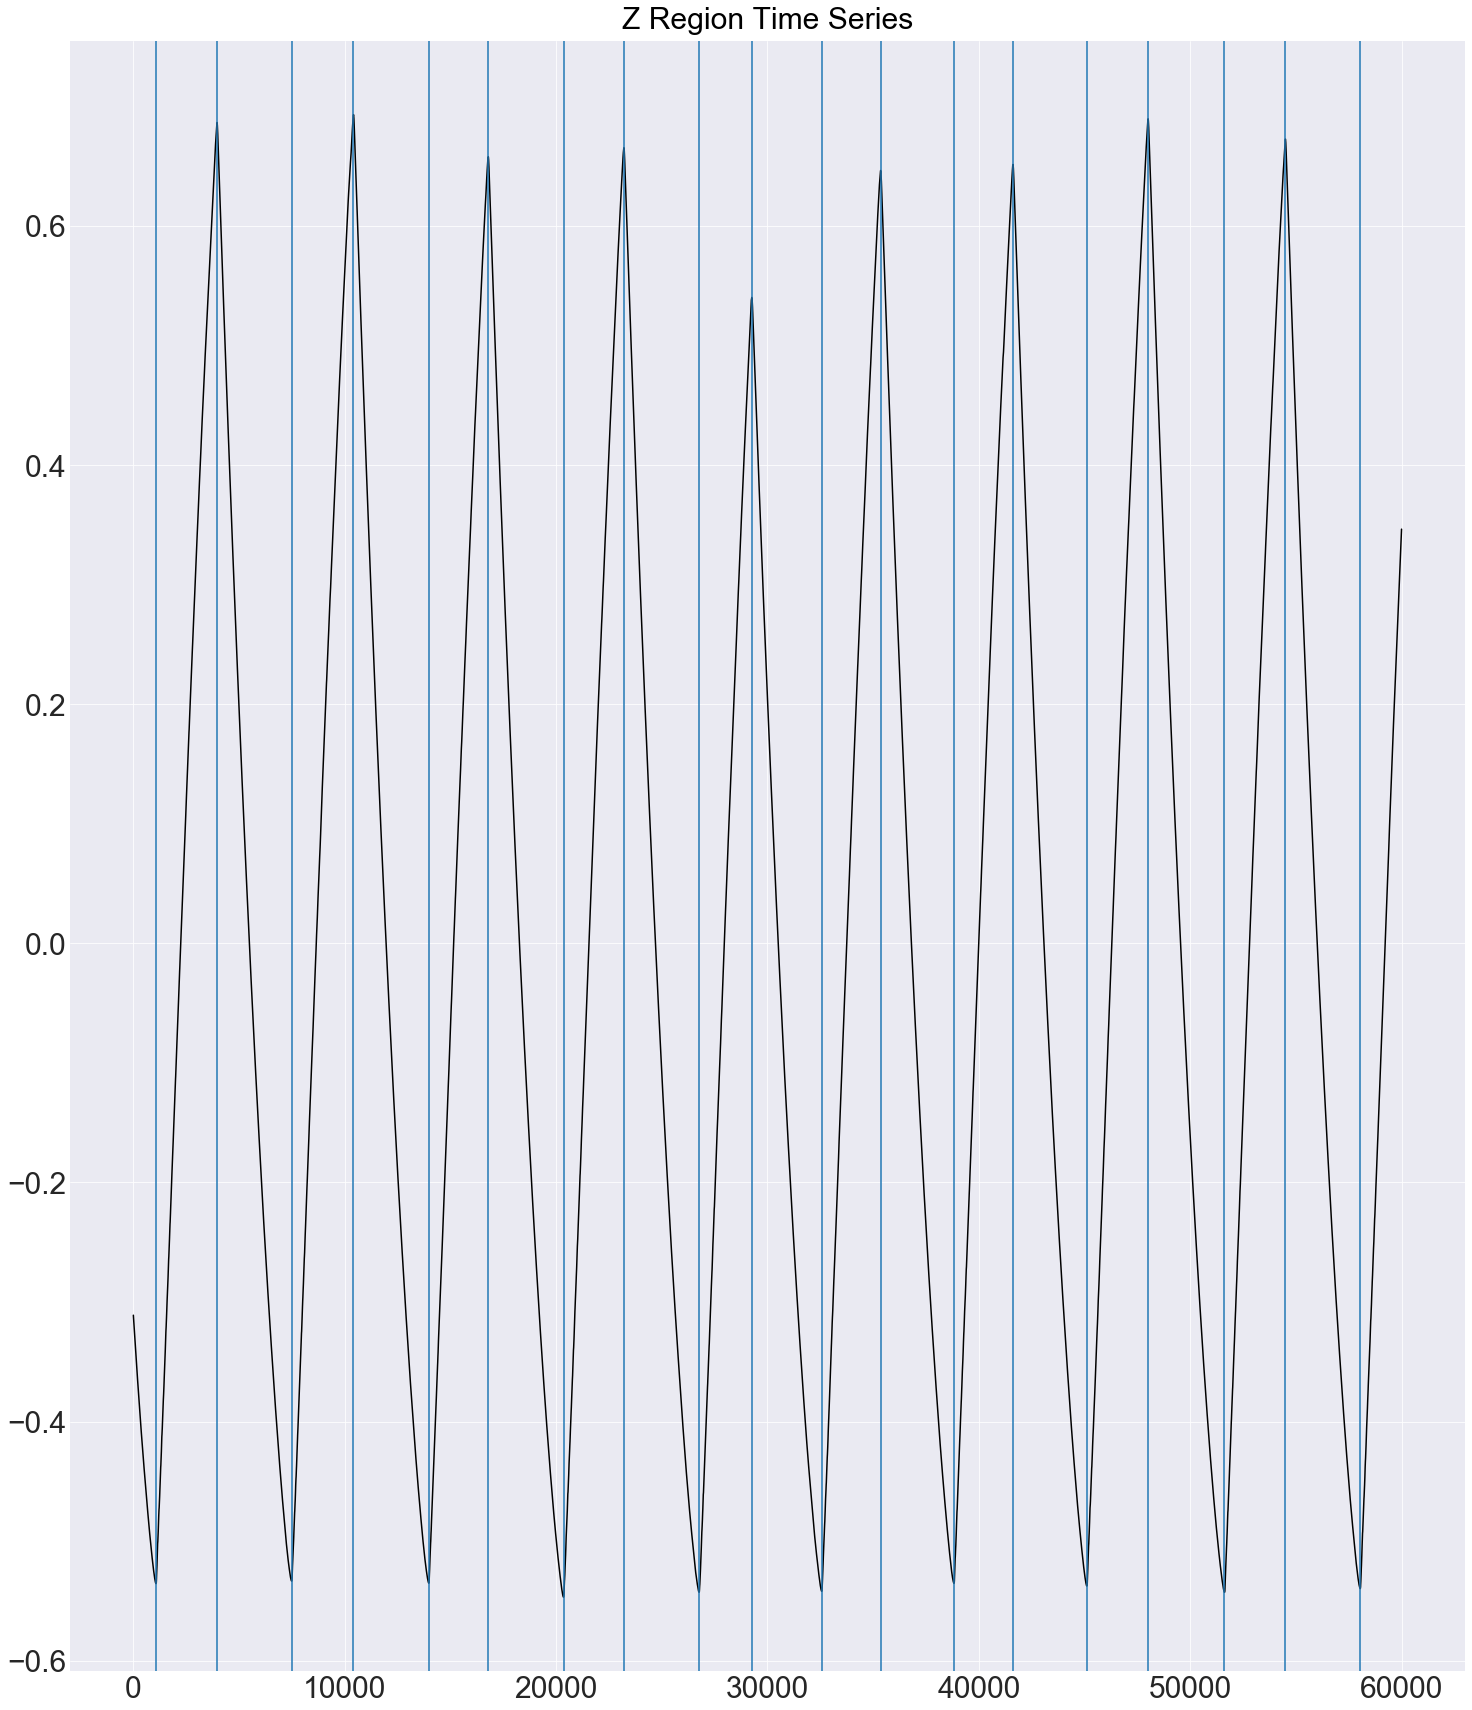

In [16]:
rawplotter.initializefig(figsize=(25,30))
if eznum > 0:
#     pass
    if len(ezindices) > 1:
        ezindices = ezindices[0]
    onsettimes, offsettimes = postprocessor.findonsetoffset(zts[ezindices, :].squeeze(), delta=0.2/8)
else:
    onsettimes = []
    offsettimes = []

for ezindex in ezindices:
    zfig = rawplotter.plotzts(zts[ezindex,:]-np.mean(zts[ezindex,:]), list(onsettimes), list(offsettimes))
    
# test = zts[pzindex,:] -np.mean(zts[pzindex,:])
# print test.shape
# rawplotter.initializefig(figsize=(25,30))
# for pzindex in pzindices:
#     zfig = rawplotter.plotzts(zts[pzindex,:]-np.mean(zts[pzindex,:]), list(onsettimes), list(offsettimes))

# rawplotter.initializefig(figsize=(25,30))  
# pzindex=0
# zfig = rawplotter.plotzts(zts[pzindex,:]-np.mean(zts[pzindex,:]), list(onsettimes), list(offsettimes))


# 2. Apply EZ To Closest Region

Here, set everything from the ez region, connectivity, node model, coupling, monitors, integrator, and parameters.

In [34]:
patient = 'id014_rb'

root_dir = os.getcwd()
project_dir = os.path.join(root_dir, "metadata/"+patient)
renamefiles(patient, project_dir)

####### Initialize files needed to 
sensorsfile = os.path.join(project_dir, "seeg.txt")
confile = os.path.join(project_dir, "connectivity.zip")
gainmatfile = os.path.join(project_dir, "gain_inv-square.txt")

con = initconn(confile)

# extract the seeg_xyz coords and the region centers
seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
seeg_labels = seeg_xyz.index.values
    
# extract the seeg_xyz coords and the region centers
region_centers = con.centres
regions = con.region_labels
num_regions = len(regions)

Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!


In [42]:
# initialize object to assist in moving seeg contacts
movecontact = tvbsim.util.MoveContacts(seeg_labels, seeg_xyz, 
                                   regions, region_centers, True)

for idx, label in enumerate(seeg_labels):
    region_index, distance = movecontact.getregionsforcontacts(label)
    
    if idx == 0:
        mindist = distance
        minregion = region_index
        mincontact = label
    else:
        if distance < mindist:
            mindist = distance
            minregion = region_index
            mincontact = label

print patient
print "Project directory for meta data is : ", project_dir
print "File to be saved is: ", filename
print mincontact
print mindist
print minregion
print regions[minregion]
sim, configs = setupconfig(epileptors, con, coupl, heunint, monitors, initcond)

id002_cj
Project directory for meta data is :  /Users/adam2392/Documents/tvb/metadata/id014_rb
File to be saved is:  /Users/adam2392/Documents/pydata/tvb_forwardsim/id002_cj/id002_cjcloseregion_TESTTESTsim_nez1_npz1.npz
B'8
[ 0.46737425]
[13]
['ctx-lh-middletemporal']


In [40]:
patient = 'id002_cj'
# 1000 = 1 second
samplerate = 1000 # Hz
sim_length = 30*samplerate

ezregion = ['ctx-lh-bankssts', 'ctx-lh-cuneus']
ezregion = ['ctx-lh-bankssts']
ezregion = regions[minregion]
#     ezregion = []
pzregion = ['ctx-lh-cuneus']
# pzregion = [] 

outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvb_forwardsim/', patient)
if not os.path.exists(outputdir):
    os.mkdir(outputdir)
filename = os.path.join(outputdir, patient+'closeregion_TESTTESTsim_nez'+str(len(ezregion))+\
                                    '_npz'+str(len(pzregion))+'.npz')

period = 1
# x0c value = -2.05
x0norm=-2.5
x0ez=-1.6
x0pz=-2.0

# intialized hard coded parameters
epileptor_r = 0.0002       # Temporal scaling in the third state variable
epiks = -0.5                 # Permittivity coupling, fast to slow time scale
epitt = 0.05               # time scale of simulation
epitau = 10                # Temporal scaling coefficient in fifth st var

# depends on epileptor variables of interest: it is where the x2-y2 var is
varindex = [1]

# parameters for heun-stochastic integrator
heun_ts = 0.05
noise_cov = np.array([0.001, 0.001, 0.,\
                0.0001, 0.0001, 0.])

print patient, " will be simulated for ", sim_length
print ezregion
print "output dir is: ", outputdir
print filename

id002_cj  will be simulated for  30000
['ctx-lh-middletemporal']
output dir is:  /Users/adam2392/Documents/pydata/tvb_forwardsim/id002_cj
/Users/adam2392/Documents/pydata/tvb_forwardsim/id002_cj/id002_cjcloseregion_TESTTESTsim_nez1_npz1.npz


In [19]:
####################### 1. Structural Connectivity ########################
con = initconn(confile)

# extract the seeg_xyz coords and the region centers
seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
seeg_labels = seeg_xyz.index.values
region_centers = con.centres
regions = con.region_labels
num_regions = len(regions)

# initialize object to assist in moving seeg contacts
movecontact = tvbsim.util.MoveContacts(seeg_labels, seeg_xyz, 
                                   regions, region_centers, True)

ezindices = movecontact.getindexofregion(ezregion)
pzindices = movecontact.getindexofregion(pzregion)

####################### 2. Neural Mass Model @ Nodes ######################
epileptors = initepileptor(epileptor_r, epiks, epitt, epitau, x0norm, \
                          x0ez, x0pz, ezindices, pzindices, num_regions)    
####################### 3. Integrator for Models ##########################
heunint = initintegrator(heun_ts, noise_cov)
################## 4. Difference Coupling Between Nodes ###################
coupl = initcoupling(a=1.)
############## 5. Import Sensor XYZ, Gain Matrix For Monitors #############
monitors = initmonitors(period, sensorsfile, gainmatfile, varindex)

# get initial conditions and then setup entire simulation configuration
initcond = initconditions(x0norm, num_regions)

In [20]:
sim, configs = setupconfig(epileptors, con, coupl, heunint, monitors, initcond)

In [21]:
times, epilepts, seegts = runsim(sim, sim_length)

postprocessor = tvbsim.util.PostProcess(epilepts, seegts, times)
######################## POST PROCESSING #################################
# post process by cutting off first 5 seconds of simulation
# for now, don't, since intiial conditions
times, epits, seegts, zts = postprocessor.postprocts(samplerate)

# get the onset, offset times
onsettimes = None
offsettimes = None
try:
    onsettimes, offsettimes = postprocessor.findonsetoffset(zts[ezindices, :].squeeze())
except:
    print "Still not working..."

######################## SAVING ALL DATA #################################
regions = configs.connectivity.region_labels
# Save files
meta = {
    'x0ez':x0ez,
    'x0pz':x0pz,
    'x0norm':x0norm,
    'regions': regions,
    'regions_centers': configs.connectivity.centres,
    'seeg_contacts': configs.monitors[1].sensors.labels,
    'seeg_xyz': configs.monitors[1].sensors.locations,
    'ez': regions[ezindices],
    'pz': regions[pzindices],
    'ezindices': ezindices,
    'pzindices': pzindices,
    'onsettimes':onsettimes,
    'offsettimes':offsettimes,
    'patient':patient,
}

# save tseries
np.savez(filename, epits=epits, seegts=seegts, \
         times=times, zts=zts, metadata=meta)

Still not working...


In [25]:
print ezindices
onsettimes, offsettimes = postprocessor.findonsetoffset(zts[ezindices, :].squeeze(), delta=0)

[13]


## 3. Do a Quick Visualization of Raw Data

In [65]:
# get the cortical surface meta data
metadatadir = os.path.join("/Users/adam2392/Documents/pydata/metadata/", patient)
cort_surf = surfaces.CorticalSurface.from_file(source_file=os.path.join(metadatadir, "surface_cort.zip"))
cort_surf.configure()
display(cort_surf.summary_info)

{'Edge lengths, longest (mm)': 11.32615848876635,
 'Edge lengths, mean (mm)': 1.0372261079362926,
 'Edge lengths, shortest (mm)': 0.018795094413170094,
 'Has two hemispheres': False,
 'Number of edges': 689340,
 'Number of triangles': 459560,
 'Number of vertices': 229784,
 'Surface type': 'CorticalSurface',
 'Valid for simulations': False}

Nbre_contacts_per_electrode: [15, 15, 15, 15, 15, 15, 15, 15, 15, 10, 10, 10]
Nbre_electrodes: 12
Ending Index of electrodes: [ 15  30  45  60  75  90 105 120 135 145 155 165]
165
165
num regions:  84
num contacts:  165
12
xreg:  (84,)
yreg:  (84,)
zreg:  (84,)
[[27]]
[]


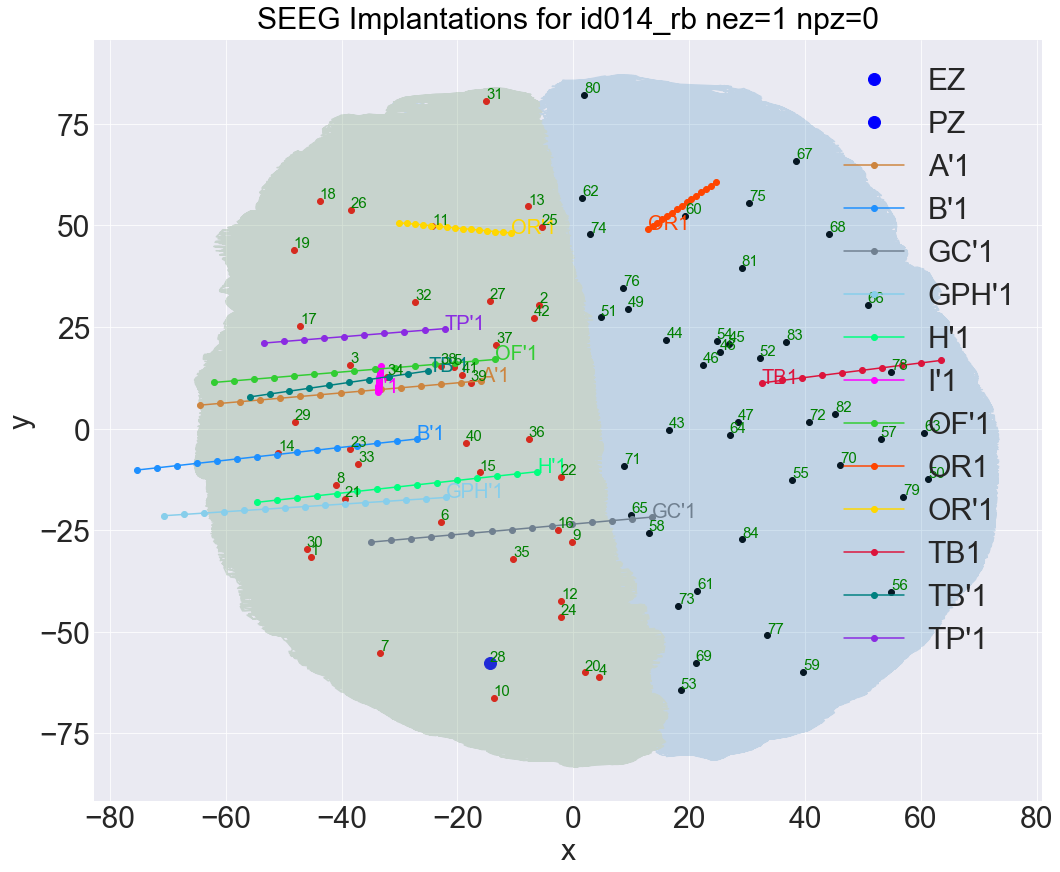

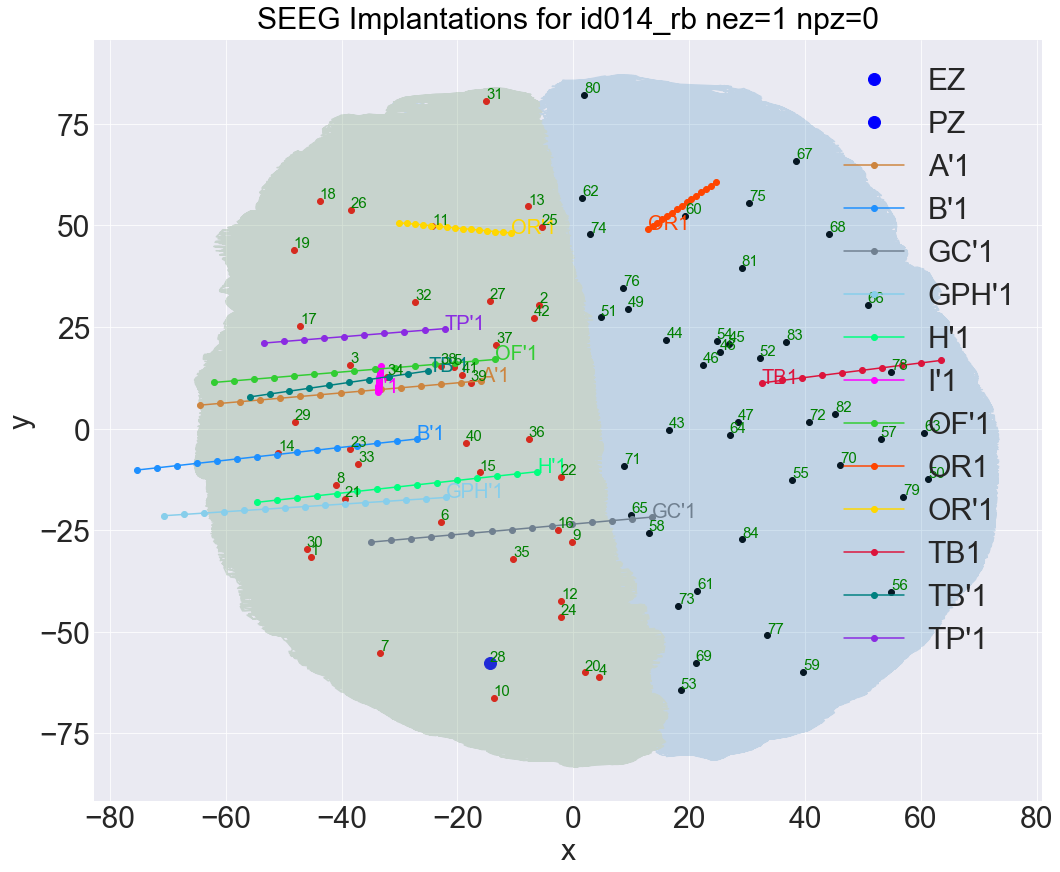

In [180]:
# read in seeg file
# seeg = pd.read_csv(os.path.join(metadatadir, "seeg.txt"), names=['x', 'y', 'z'], delim_whitespace=True)
# seeg_labels = seeg.index
# seeg_xyz = seeg.as_matrix()
seeg_labels = meta['seeg_contacts']
seeg_xyz = meta['seeg_xyz']

elect = []
dipole = []

# create lists of elect and dipoles
for element in range(0,seeg.shape[0]):
    kpm = np.array(re.match("([A-Z]+[a-z]*[']*)([0-9]+)", seeg_labels[element]).groups())
    elect.append(kpm[0])
    dipole.append(int(kpm[1]))

'''
Descrip: 
- Number of electrodes is : len(find_0)
- Number of contacts per an electrode i is nbr_contacts[i+1]

''' 
# find the beginning index of each electrode
find_0 = []
nbr_contacts = []
for element_1 in range(0, len(dipole)):
    if dipole[element_1] == 1:
        find_0.append(element_1)
for element_2 in range(0, len(find_0)-1):
    nbr_contacts.append(find_0[element_2+1]-find_0[element_2])
nbr_contacts.append(len(seeg_labels)- find_0[len(find_0)-1])

# Find the list of the ending index of each electrode
incr_cont = np.zeros((len(nbr_contacts)), dtype=int)
incr_cont[0] = 0

for element_4 in range(0, len(nbr_contacts)):
    incr_cont[element_4] = incr_cont[element_4-1] + nbr_contacts[element_4]

    
print "Nbre_contacts_per_electrode:", nbr_contacts
print "Nbre_electrodes:", len(nbr_contacts)
print "Ending Index of electrodes:", incr_cont # To plot each electrode with diff color

print sum(nbr_contacts) # to be sure that the code is correct
print len(seeg_labels)

rawplotter.initializefig(figsize=(17,14))
rawplotter.plotcontactsinbrain(cort_surf, region_centers, regions, seeg_xyz, seeg_labels, incr_cont, patient, ezindices, pzindices=[])